# Performance

## Avoiding slow code

With pandas, you'll get the most bang for your buck by *avoiding antipatterns*.
There are additional options like using Numba or Cython if you *really* need to optimize a piece of code, but that's more work typically.

This notebook will walk through several common miskates, and show more performant ways of achieving the same thing.

In [1]:
import sys
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10
plt.style.use('default')

In [2]:
%matplotlib inline

## Mistake 1: Using pandas

- At least not for things it's not meant for.
- Pandas is very fast at joins, reindex, factorization
- Not as great at, say, matrix multiplications or problems that aren't vectorizable

## Mistake 2: Using object dtype

Avoid it if possible

Jake VanderPlas has a [great article](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/) on why Python is slow for many of the things we care about as analysts / scientists.
One reason is the overhead that comes from using python objects for integers, floats, etc. relative to the native versions.

As a small demonstration, we'll take two series, one with python integers, and one with NumPy's `int64`.

In [3]:
# Two series of range(10000), different dtypes
s1 = pd.Series(range(10000), dtype=object)
s2 = pd.Series(range(10000), dtype=np.int64)

In [4]:
%timeit s1.sum()

1.06 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
%timeit s2.sum()

125 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


NumPy can process the specialized `int64` dtype array faster than the python object version, even though they're equal.

Typically you would never expecitly pass in `dtype=object` there, but occasionally object dtypes slip into pandas

1. Strings

    This is usually unavoidable. Pandas 2 will have a specialized string
    type, but for now you're stuck with python objects. If you have few
    *distinct* values (relative to the number of rows), you could use a
    `Categorical`
<br><br>
2. Dates, Times

    Pandas has implemented a specialized verion of `datetime.datime`,
    and `datetime.timedelta`, but not `datetime.date` or `datetime.time`.
    Depending on your application, you might be able to treat dates as `datetimes`s, at midnight.
<br><br>
3. Decimal types

    Pandas uses floating-point arrays; there isn't a native arbitrary-precision Decimal type.
<br><br>
4. Reading messy Excel Files

    `read_excel` will preserve the dtype of each cell in the spreadsheet. If you
    have a single column with an int, a float, and a datetime, pandas will have to store all of those as `objects`. This dataset probably isn't tidy though.
<br><br>

5. Messy CSVs where pandas' usual inference fails
<br><br>
6. Integer NA

    Unfortunately, pandas doesn't have real nullable types. To represent
    missingness, pandas uses `NaN` (not a number) which is a special floating point value. If you *have* to represent nullable integers, you can use `object` dtype.

In [6]:
s = pd.Series([1, 2, 3, np.nan, 5, 6, 7, 8, 9])
s

0    1.0
1    2.0
2    3.0
3    NaN
4    5.0
5    6.0
6    7.0
7    8.0
8    9.0
dtype: float64

In [7]:
type(s[0])

numpy.float64

In [8]:
s = pd.Series([1, 2, 3, np.nan, 5, 6, 7, 8, 9], dtype=object)
type(s[0])

int

## Aside: Managing Dtypes

Pandas provides some tools for converting arrays to their specialized dtype.

0. IO operations (`read_csv` infers, but can use the `dtype` keyword)
1. Object -> numeric: `pd.to_numeric`
2. Object -> datetime: `pd.to_datetime`
3. Object -> timedelta: `pd.to_timedelta`
4. Object -> category: `pd.Categorical`
5. `.astype(dtype)`

They're pretty flexible what they accept.

In [9]:
numbers = ['1', '2', '3.', 'nan']
pd.to_numeric(numbers, errors='coerce')

array([  1.,   2.,   3.,  nan])

In [10]:
dates = ['2016/01/01', '2016/02/01', '2016/03/01']
pd.to_datetime(dates)

DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01'], dtype='datetime64[ns]', freq=None)

In [11]:
# to_timedelta
x = pd.to_timedelta(['1H', '30s', '20blah'], errors='coerce')
x

TimedeltaIndex(['01:00:00', '00:00:30', NaT], dtype='timedelta64[ns]', freq=None)

In [12]:
pd.to_timedelta([10, 20, 30], unit="T")  # T = minutes

TimedeltaIndex(['00:10:00', '00:20:00', '00:30:00'], dtype='timedelta64[ns]', freq=None)

In [13]:
pd.Categorical(['a', 'a', 'c', 'b'], categories=['a', 'b', 'c'],
               ordered=True)

[a, a, c, b]
Categories (3, object): [a < b < c]

## Aside: Categoricals

Pandas has a custom datatype, `Categorical`, for representing data that can come from a specified, generally fixed set of values.

- `categories`: set of valid values
- `ordered`: whether that set of values has an ordering

In [14]:
c = pd.Categorical(['a', 'b', 'c', 'a'], categories=['a', 'b', 'c', 'd'])
c

[a, b, c, a]
Categories (4, object): [a, b, c, d]

Trying to insert a value that is outside the set of categories will cause an exception.

In [15]:
c[0] = 'f'

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

## Categoricals: Space Efficient

Suppose you had to store a column with the home state for 321 million Americans.
If you simply stored the text abbreviations like `['AL', 'AL', 'CA', 'IA', ...]` for all 321 million, you'd need

In [16]:
N = 321_000_000
bytes_per = sys.getsizeof("AL")  # two characters per state
print(f"{N * bytes_per / 10**9:.2f} GB")

16.37 GB


On the other hand, if you store

1. Each of the 50 text abbreviations once
2. An integer code for each of the 321 million people

you'd need

In [17]:
character_bytes = 50 * sys.getsizeof("CA")
bytes_per_person = 2  # np.int16 = 2 bytes
print(f"{(character_bytes + N * bytes_per_person) / 10**9:.2f} GB")

0.64 GB


That's what Categoricals do internally. The set of categories [`'a', 'b', 'c', 'd']`, are stored *once*, and is availble with the `.categories` attribute.

The values `['a', 'b', 'c', 'a']` aren't actually stored anywhere. Rather, an array of integer `codes` like `[0, 1, 2, 0]`, indiciating the position in `categories` is stored.

In [18]:
c.categories

Index(['a', 'b', 'c', 'd'], dtype='object')

In [19]:
c.codes

array([0, 1, 2, 0], dtype=int8)

In [20]:
c

[a, b, c, a]
Categories (4, object): [a, b, c, d]

Since an integer generally takes less memory to store than a string, these are an efficient way of representing data that has many repetitions. Categoricals can be stored in a DataFrame, Series, or index

In [21]:
pd.Series(c)

0    a
1    b
2    c
3    a
dtype: category
Categories (4, object): [a, b, c, d]

Pandas can take shortcuts when you use the proper dtypes.

**For example, the algorithms for `value_counts` and `groupby` are simplier, and thus faster, for Categoricals than for strings (object).**

## Mistake 3: Initialization

When your collecting many different sources (say a bunch of separate CSVs) into
a single DataFrame, you have two paths to the same goal:

1. Make a single empty DataFrame, append to that
2. Make a list of many DataFrames, concat at end

Typically, in python we'd choose the first one if we were, for example, collecting things into a `list`. `list.append` is very fast. However `DataFrame.append` is *not* fast.

Let's make some fake datasets to work with

In [22]:
import string
import random

records = [[(random.choice(string.ascii_letters),
             random.choice(string.ascii_letters),
             random.choice(range(10)))
            for i in range(50)]
           for j in range(100)]

So we have 100 sets of 50 records each.
This could represent any datasource, say 100 different CSVs, with any number of items in each.

Each subset can be represented as a DataFrame

In [23]:
records[0][:10]

[('U', 'Z', 7),
 ('f', 'E', 4),
 ('C', 'W', 7),
 ('f', 'z', 5),
 ('R', 'j', 2),
 ('s', 'w', 4),
 ('i', 'A', 1),
 ('h', 'r', 7),
 ('b', 'e', 5),
 ('k', 'x', 3)]

In [24]:
pd.DataFrame(records[0], columns=['A', 'B', 'C'])

,A,B,C
0,U,Z,7
1,f,E,4
2,C,W,7
3,f,z,5
4,R,j,2
...,...,...,...
45,m,t,3
46,v,O,7
47,a,f,2
48,B,Q,1


## The wrong way: DataFrame.append

In [25]:
%%timeit
# Make an empty dataframe with the correct columns
df = pd.DataFrame(columns=['A', 'B', 'C'])

for set_ in records:
    subdf = pd.DataFrame(set_, columns=['A', 'B', 'C'])
    # append to that original df
    # DataFrame.append is not inplace!
    df = df.append(subdf, ignore_index=True)

165 ms ± 4.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<div class="alert alert-success" data-title="Concat vs. Append">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Concat vs. Append</h1>
</div>

<p>Combine the set of records into a single DataFrame using `pd.concat`</p>

Hints:

- Make a list of dataframes using a list comprehension
- Use `ignore_index=True` in `concat` to avoid duplicaes
- add a `%%timeit` magic to time your solution

In [29]:
%%timeit

dfs = [pd.DataFrame(set_, columns=['A', 'B', 'C']) for set_ in records]
df = pd.concat(dfs, ignore_index=True)

77.1 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Mistake 4: Doing too much work

This is more general purpose advice, rather than something you can just grep your code for.
But look for places where you're doing a bunch of work, and then throwing some of it away. **Remember:** if `pandas` has something that does what we want, it is likely that it is faster than your reinvent-the-wheel version.

In [30]:
# read in dep_delay column from flights
delays = pd.read_parquet('data/ny-flights.parq')['dep_delay']
delays.head()

0    14.0
1    -3.0
2     2.0
3    -8.0
4     2.0
Name: dep_delay, dtype: float64

Suppose we wanted to find the 5 longest delays. One option is to sort the entire Series and then take the head

In [31]:
%timeit delays.sort_values(ascending=False).head(5)

1.94 ms ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


A better option is to use the `nlargest` method on `Series`, and then sort just those 5 elements.

In [32]:
%timeit delays.nlargest(5).sort_values(ascending=False)

1.28 ms ± 32.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In can be hard to remember all the methods or algorithms available to you though.
I think this one just comes down to experience.

For another example, let's suppose we wanted to find the nearest neighbor for a bunch of points.
A naïve implementation would find the ~$N^2$ pairwise distances, and then go through finding the nearest neighbor for each.
This becomes untenable for large $N$.
Fortunately, we can be more efficient using [KDTrees](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) instead of finding all pairwise distances.
For very large $N$, various [probabilistic algorithms](https://github.com/ekzhu/datasketch) are available, but we won't talk about those today.

<div class="alert alert-success" data-title="Nearest Neighbor">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Nearest Neighbor</h1>
</div>

<p>Find the nearest neighbor for all the airports with at least 500 departures.</p>

The naïve way to do this is to compute a pairwise distance matrix of all 500 airports, and then lookup the closest neighbor for each airport.

Let's avoid that unnescessary computation by using a `KDTree` - **you did not do this exercise since it involves `KDTree`**

In [ ]:
# Step 1: read in `data/flights_coord.csv`. Call the DataFrame coord
coord = pd.read_csv("data/flights_coord.csv")
coord.head() 

I don't know why, but apparently `AIRPORT_ID` isn't unique:

In [ ]:
coord.AIRPORT.is_unique

You can use `.groupby().first()` to arbitrarily select the first one per airport:

In [ ]:
locs = coord.groupby('AIRPORT')[['LONGITUDE', 'LATITUDE']].first()
locs.head()

Step 3: Use [`sklearn.neighbors.KDTree`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) to find the nearest neighbors.
It's OK if you haven't used scikit-learn before; I've provided stubs of a solution below.
I'd recommend making additional cell to check the intermediate values as you solve each step.

And if you get stuck, the solution is provided afterwards.
Feel free to read through it and the KDTree docs.

In [ ]:
from sklearn.neighbors import KDTree

tree = KDTree(...)  # see the docs (linked above) for KDTree

# Now use `tree.query` to find the distances and
# nearest neighbor. Make sure to pass a NumPy array to `.query`
# and not a DataFrame; otherwise scikit-learn gets confused.
# `locs.values` returns a NumPy array.

# How many neighbors (k=...) do we need? Keep in mind that
# we're searching on the same data as we built the tree on,
# so what's the "closest" point for each observation?
distances, indexes = tree.query(locs.values, k=...)

# slice the NumPy arrays to just what we need
# The array is shaped [n_observations, k] where `k` is
# what you passed to query. Column 0 is the closest,
# Column 1 is the second closest, etc...

indexes = indexes[:, 1]
distances = distances[:, 1]

# the result of KDTree.query is a list of index
# *positions*, we'll use id_map to go from 
# positions back to airport names
id_map = dict(enumerate(locs.index))

neighbors = pd.Series(indexes, index=locs.index).map(id_map)
neighbors.head()

In [ ]:
# %load solutions/performance_02.py
from sklearn.neighbors import KDTree

# the result of KDTree.query is a list of index
# *positions*, we'll use id_map to go from
# positions back to airport names
id_map = dict(enumerate(locs.index))

tree = KDTree(locs)

distances, indexes = tree.query(locs.values, k=2)
indexes = indexes[:, 1]
distances = distances[:, 1]
neighbors = pd.Series(indexes, index=locs.index).map(id_map)
neighbors.head()


## Mistake 5: Using `.apply` (with axis=1) (Avoid Iteration)

I see this one a lot. I don't like absolutes, but you should never use `.apply(..., axis=1)` (probably).
The root problem is using for loops instead of a vectorized solution.
That is, something like:

In [33]:
a = range(10)
b = range(10)
c = [a_ + b_ for a_, b_ in zip(a, b)]
c

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

Instead of the vectorized version:

In [34]:
a = np.arange(10)
b = np.arange(10)
c = a + b
c

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

http://www.labri.fr/perso/nrougier/from-python-to-numpy/ is a great resource for learning about vectorized methods.

As a demonstration, let's dip into survival analysis. **Another bad example of too fancy model - you did not do it.**
This is (roughly) the study of how much longer something will last (survive) given their current history.
For example, how much longer will someone continue to be a customer, given their past purchases?

In [35]:
from lifetimes.datasets import load_cdnow
from lifetimes import BetaGeoFitter

data = load_cdnow(index_col=[0])

data.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


These are all customer-level statistics:

- frequency: number of repeat purchases
- T: "age" of the customer (units since first purchase)
- recency: age at time of last purchase

The `lifetimes.BetaGeoFitter` model has a scikit-learn-like API to estimate several parameters and has several utility methods.

In [36]:
# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T']);

/home/yixian/anaconda3/envs/ph2t/lib/python3.6/site-packages/lifetimes/estimation.py:578: RuntimeWarning: invalid value encountered in log
  A_4 = log(a) - log(b + freq - 1) - (r + freq) * log(rec + alpha)


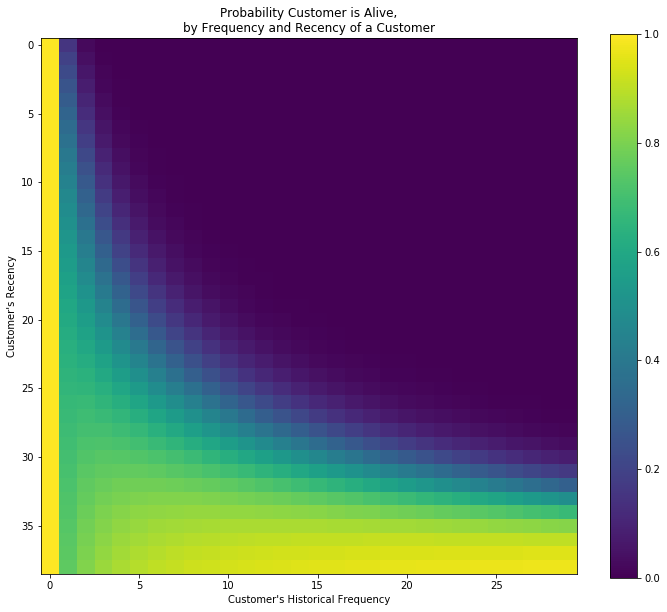

In [37]:
from lifetimes.plotting import plot_probability_alive_matrix
plt.figure(figsize=(12, 10))
plot_probability_alive_matrix(bgf, cmap='viridis');

[Apparently](http://mktg.uni-svishtov.bg/ivm/resources/Counting_Your_Customers.pdf), we can calculate the expected number of purchases over the next $t$ periods with

\begin{align*}
    E\left(X(t) \vert \lambda, p\right) &= \lambda t \cdot P(\tau > t) + \int_0^t \lambda \tau g(\tau \vert \lambda, p)  \tau \\
    &= \frac{1}{p} - \frac{1}{p} e^{-\lambda pt}
\end{align*}

With some fancy math and substitutions, the following calculation does that.

In [ ]:
from scipy import special

r, α, a, b = bgf._unload_params('r', 'alpha', 'a', 'b')
print(r, α, a, b)

def conditional_n_purchases(t, frequency, recency, T):
    x = frequency

    hyp_term = special.hyp2f1(r + x, b + x, a + b + x - 1, t / (α + T + t))
    first_term = (a + b + x - 1) / (a - 1)
    second_term = (1 - hyp_term * ((α + T) / (α + t + T)) ** (r + x))
    numerator = first_term * second_term

    denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((α + T) / (α + recency)) ** (r + x)

    return numerator / denominator

In [ ]:
conditional_n_purchases(t=5, frequency=2, recency=30.43, T=38.86)

Originally, `lifetimes`' documentation had code similar to the following:

In [ ]:
data.apply(lambda row: conditional_n_purchases(5,
                                               row['frequency'],
                                               row['recency'],
                                               row['T']),
           axis=1)

Notice that's doing a `.apply(..., axis=1)`. Let's time it

In [ ]:
%%timeit
t = 5
# Using .apply(λ row:, axis=1)
data.apply(lambda row: conditional_n_purchases(5,
                                               row['frequency'],
                                               row['recency'],
                                               row['T']),
           axis=1)

You almost never want to use `.apply` with axis=1. `.apply` It's probably doing way more work that you actually want, including:

- A bunch of type inference
- Some "helpful" reductions of output shape
- Is essentially a for loop internally

If you *have* to use an interative solution (instead of vectorized), use `.itertuples` which returns an iterator of `namedtuples`.

In [ ]:
next(data.itertuples())

Exercise: Use `.itertuples` to call `conditional_n_purchases` on each row in `data`.

- Make sure to wrap the list of results in a in a `Series`
- Time your solution

In [ ]:
%%timeit
t = 5
pd.Series([
    conditional_n_purchases(t, row.frequency, row.recency, row.T)
    for row in data.itertuples()
])

<div class="alert alert-success" data-title="Vectorized">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Vectorized Solution</h1>
</div>


Can we improve on that? Look at the functions we use in `conditional_n_purchases`. Do they take scalars, arrays, or either?

In [ ]:
t = 5
conditional_n_purchases(t, data['frequency'], data['recency'], data['T'])

It's quite natural to say "I have this complicated function `f` to apply to each 
row, I'll just just use `.apply(f, axis=1)`". Avoid that temptation.

## Summary

- Get good performance by avoiding antipattern
- Avoid `object` dtype where possible
- Avoid iteration where possible